In [1]:
pip install Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_csv_column_names(folder_path, num_workers=4):
    column_names_dict = {}
    
    # Function to read column names from a CSV file
    def read_columns(file_path):
        try:
            df = pd.read_csv(file_path, nrows=0)
            return file_path, df.columns.tolist()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return file_path, []

    # Traverse the directory and get all CSV file paths
    csv_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_file = {executor.submit(read_columns, file): file for file in csv_files}
        
        for future in as_completed(future_to_file):
            file_path, columns = future.result()
            file_name = os.path.basename(file_path)
            column_names_dict[file_name] = columns

    return column_names_dict

# Example usage
folder_path = 'path/to/your/folder'
num_workers = 4
column_names_dict = get_csv_column_names(folder_path, num_workers)
print(column_names_dict)




{}


In [3]:
column_names_dict

{}

In [4]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
# concatenating first train data and test data, helpfull for applying same imputation and feature enginnearing.
data = pd.concat([data, test], ignore_index=True)
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [6]:
data['NoOfPassenger'] = data["PassengerId"].apply(lambda x: int(x[-2:]))  # 03 passenger
data['PassengerId'] = data["PassengerId"].apply(lambda x: x[:4])          # 0013 passenger id
data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
data['ExpenseInShip'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
sbsp = data.groupby(("PassengerId")).NoOfPassenger.count()
data = pd.merge(data, sbsp, on='PassengerId', how='inner')
data['SibSp'] = data['NoOfPassenger_y']
data.drop(columns= ['NoOfPassenger_x', 'NoOfPassenger_y'], inplace=True)
data['surname'] = data.Name.apply(lambda x: x.split()[1] if type(x) == str else x)
data['Cabin'] = data['Cabin'].apply(lambda x: str(x).split('/') if pd.notna(x) and x != -1 else x)
data['deck'] = data['Cabin'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
data['num'] = data['Cabin'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
data['side'] = data['Cabin'].apply(lambda x: x[2] if isinstance(x, list) and len(x) > 2 else np.nan)

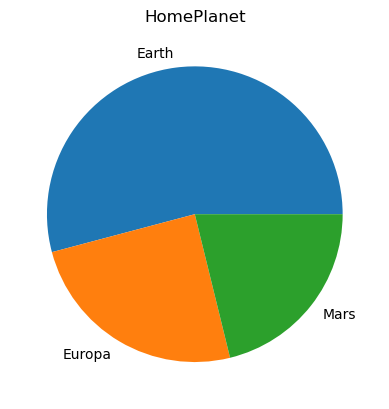

In [7]:
plt.pie(data.HomePlanet.value_counts(),labels = ['Earth','Europa','Mars'])
plt.title("HomePlanet")
plt.show()

In [8]:
data[data.VIP == True].HomePlanet.value_counts()

Europa    177
Mars       90
Name: HomePlanet, dtype: int64

In [9]:
data[(data.VIP == True) & (data.HomePlanet == "Mars")].CryoSleep.value_counts()

False    88
Name: CryoSleep, dtype: int64

In [10]:
# function for fillng missing values
def fill_homeplanet(row):
    if pd.notna(row['HomePlanet']):
        return row['HomePlanet']

    if (pd.notna(row['VIP']) and pd.notna(row['CryoSleep'])):
        if row['VIP'] and row['CryoSleep'] == False:              # if VIP = True and Cryosleep = False
            return 'Mars'

    if pd.notna(row['VIP']):
        return 'Europa' if row['VIP'] else 'Earth'
    return row['HomePlanet']

data['HomePlanet'] = data.apply(fill_homeplanet, axis=1)

In [11]:
data.HomePlanet.isnull().sum()

3

In [12]:
data.HomePlanet.fillna("Earth", inplace=True)

In [13]:
data[(data.ExpenseInShip == 0.0) & (data.CryoSleep == False) & (data.Age <= 18)].VIP.value_counts()

False    577
Name: VIP, dtype: int64

In [14]:
data[(data.ExpenseInShip == 0.0) & (data.Age > 18)].CryoSleep.value_counts()

True     3223
False     136
Name: CryoSleep, dtype: int64

In [15]:
def fill_cryosleep(row):
    if pd.notna(row['CryoSleep']):
        return row['CryoSleep']
    if row['ExpenseInShip'] == 0 and row['Age'] <= 18 and row['VIP'] == False:
        return False
    if row['ExpenseInShip'] == 0:
        return True
    else:
        return False
data['CryoSleep'] = data.apply(fill_cryosleep, axis=1)

In [16]:
data.Cabin.isnull().sum()

299

In [17]:
data[data.PassengerId == '0992']
# see same passenger_id travelling in the same Cabin.

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,ExpenseInShip,SibSp,surname,deck,num,side
925,0992,Europa,False,"[D, 35, S]",TRAPPIST-1e,49.0,False,31.0,2727.0,0.0,184.0,135.0,Zino Kiling,True,3077.0,6,Kiling,D,35,S
926,0992,Europa,False,"[D, 35, S]",TRAPPIST-1e,29.0,False,387.0,942.0,0.0,9927.0,1341.0,Tareson Kiling,False,12597.0,6,Kiling,D,35,S
927,0992,Europa,False,"[D, 35, S]",55 Cancri e,46.0,False,1192.0,1736.0,17.0,21.0,0.0,Matan Herpumble,True,2966.0,6,Herpumble,D,35,S
928,0992,Europa,False,NaN,55 Cancri e,35.0,True,8030.0,300.0,0.0,0.0,1436.0,Naosa Herpumble,False,9766.0,6,Herpumble,NaN,NaN,NaN
929,0992,Europa,True,"[D, 35, S]",55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Sinon Kiling,True,0.0,6,Kiling,D,35,S
930,0992,Europa,False,"[D, 35, S]",55 Cancri e,37.0,False,4301.0,791.0,0.0,1748.0,91.0,Weidus Kiling,False,6931.0,6,Kiling,D,35,S


In [18]:
# taking mode of Cabin, where same passenger id 
def get_mode(data, passId):
    subset = data[data.PassengerId == passId]
    fill_with = subset.Cabin.mode()
    if len(fill_with) <= 0:
        return np.nan
    return fill_with[0]

subset = data[data.Cabin.isnull()]

msID = subset.PassengerId
filled = []
for i in msID:
    filled.append(get_mode(data,i))
    

my_d = pd.DataFrame()
my_d['PassengerId'] = msID
my_d['filled_cabin'] = filled

merged_df = data.merge(my_d, on='PassengerId', how='left')
merged_df['filled_cabin'].fillna(merged_df['Cabin'], inplace=True)
merged_df.rename(columns={'filled_cabin': 'Cabin1'}, inplace=True)

merged_df.Cabin = merged_df.Cabin.astype(str)
merged_df.Cabin1 = merged_df.Cabin1.astype(str)

data.drop(columns = 'Cabin', inplace=True)
data.rename(columns={'Cabin1': 'Cabin'}, inplace=True)

merged_df = merged_df.drop_duplicates()

data = merged_df
data.drop(columns = 'Cabin', inplace=True)
data.rename(columns={'Cabin1': 'Cabin'}, inplace=True)

In [19]:
import ast
def convert_to_list(s):
    if s != 'nan':  # Check if the value is not NaN
        return ast.literal_eval(s)
    return None


# Apply the conversion function to the Series
data.Cabin = data.Cabin.apply(lambda x: convert_to_list(x))

In [20]:
data['deck'] = data.Cabin.apply(lambda x: x[0] if isinstance(x, list) else np.nan)
data['num'] = data.Cabin.apply(lambda x: x[1] if isinstance(x, list) else np.nan)
data['side'] = data.Cabin.apply(lambda x: x[2] if isinstance(x, list) else np.nan)

In [21]:
data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,ExpenseInShip,SibSp,surname,deck,num,side,Cabin
0,0001,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,1,Ofracculy,B,0,P,"[B, 0, P]"
1,0002,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1,Vines,F,0,S,"[F, 0, S]"
2,0003,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,2,Susent,A,0,S,"[A, 0, S]"
3,0003,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,2,Susent,A,0,S,"[A, 0, S]"
4,0004,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1,Santantines,F,1,S,"[F, 1, S]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,9266,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,0.0,2,Peter,G,1496,S,"[G, 1496, S]"
12974,9269,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,1018.0,1,Scheron,NaN,NaN,NaN,None
12975,9271,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,0.0,1,Pore,D,296,P,"[D, 296, P]"
12976,9273,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,3203.0,1,Conale,D,297,P,"[D, 297, P]"


In [22]:
data.deck.fillna(data.deck.mode()[0], inplace=True)
subset_data = data[data['deck'] == 'F']
# knn-imputation
X = subset_data['num'].values.reshape(-1, 1)
knn_imputer = KNNImputer(n_neighbors=4)
imputed_values = knn_imputer.fit_transform(X)
data.loc[data['deck'] == 'F', 'num'] = imputed_values
data.side.fillna(data.side.mode()[0], inplace=True)
data.drop(columns = ['Cabin'], inplace = True)
missing_destination_surname = data[data.Destination.isnull()]['surname'].values[0]
subset_data = data[data['surname'] == missing_destination_surname]
mode_destination = subset_data['Destination'].mode().values[0]
data.loc[data['Destination'].isnull(), 'Destination'] = mode_destination
data.drop(columns = ['Name', 'surname','PassengerId'], inplace=True)
data.Age.fillna(data.Age.mean(), inplace = True)
data.VIP.fillna(data.VIP.mode()[0], inplace = True)

In [23]:
data['CryoSleep'] = data['CryoSleep'].astype(object)
data['VIP'] = data['VIP'].astype(object)
data['SibSp'] = data['SibSp'].astype(object)
# data['Transported'] = data['Transported'].astype(int)

In [24]:
data['num'] = data['num'].astype(int)

In [25]:
train_data = data.loc[:8692]
train_data['Transported'] = train_data['Transported'].astype(int)
test_data = data.loc[8693:].drop(columns = 'Transported')

In [26]:
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ExpenseInShip,SibSp,deck,num,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,736.0,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,10383.0,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,5176.0,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,1091.0,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,0,8536.0,1,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,1,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,1,1873.0,1,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,0,4637.0,2,E,608,S


In [27]:
import numpy as np 
import pandas as pd 
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import re
from itertools import combinations
import Levenshtein
from collections import defaultdict
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


class generic_Utilities:
    '''Generic Utilities on Lists and Dataframes'''
    def __init__(self):
        self.allFunctions = {}
        self.allFunctions['List_Operartion_1'] = str("Function: intersection_of_lists(list1, list2), Returns : list3")
        self.allFunctions['List_Operartion_2'] = str("Function: difference_of_lists(list1, list2), Returns : list4")
        
        self.allFunctions['Folder_Operartion_1'] = str("Function: get_csv_column_names(folder_path, num_workers=4), Returns : column_names_dict")
        
        self.allFunctions['Plot_Operartion_1'] = str("Function: plot_NumericVscumSum(x, y), Returns : None")
        self.allFunctions['Plot_Operartion_2'] = str("Function: logistic_regression_with_roc(X, y), Returns: test_roc_auc")
        self.allFunctions['Plot_Operartion_3'] = str("Function: cart_with_roc(X, y), Returns: test_roc_auc")
        
        self.allFunctions['Dictionary_Operartion_1'] = str("Function: filter_and_sort_subsets(subset_counts, threshold), Returns: sorted_subsets")
        
        self.allFunctions['Dataframe_Operartion_1'] = str("Function: get_numeric_and_non_numeric_columns(df), Returns: list4, list5")
        self.allFunctions['Dataframe_Operartion_2'] = str("Function: remove_single_unique_or_all_nans(df), Returns: df")
        self.allFunctions['Dataframe_Operartion_3'] = str("Function: columns_with_missing_values(df), Returns: list6")
        self.allFunctions['Dataframe_Operartion_4'] = str("Function: fill_col_with_median(df, colNames), Returns: df")
        self.allFunctions['Dataframe_Operartion_5'] = str("Function: columns_with_more_than_X_percent_unique(df, colNames, perc), Returns: list7")
        self.allFunctions['Dataframe_Operartion_6'] = str("Function: convert_and_create_factorizedColumns(df, colNames), Returns: df, mapDict")
        self.allFunctions['Dataframe_Operartion_7'] = str("Function: fillMissing_predictFactorizedColumns(df, usable_cols, colName), Returns: df, mapDict")
        self.allFunctions['Dataframe_Operartion_9'] = str("Function: oneHotEncoded(df, columns_to_oneHot), Returns: new_df")
        
        self.allFunctions['FeatureEngineering_Operartion_1'] = str("Function: train_subset_counts_oneHot(df, target, value, options= COUNT, WIG, empericalProb, n_jobs=1), Returns: subset_counts")
        self.allFunctions['FeatureEngineering_Operartion_2'] = str("Function: train_LeastSquareSpline_fit(df, target, variable, degree), Returns: breakpoints_original")
        self.allFunctions['FeatureEngineering_Operartion_3'] = str("Function: train_UnivariateSpline_fit(df, target, variable, threshold), Returns: breakpoints_original")
        self.allFunctions['FeatureEngineering_Operartion_4'] = str("Function: train_cart_bins_with_plot(df, variableCol, targetCol, max_n_bins, n_jobs=1), Returns: breakpoints_original")
        
        self.allFunctions['FeatureCreation_Operartion_1'] = str("Function: create_combinedFeatures_df(df, required_cols, wanted_subsets,  options = INT, FRACTION), Returns: new_df")
        self.allFunctions['FeatureCreation_Operartion_2'] = str("Function: create_one_hot_encode_ranges(df, colName, required_columns, breakpoints), Returns: new_df")
       
        self.loadedFunctions = {}
        return None
        
        
    def get_csv_column_names(self, folder_path, num_workers=4):
        self.loadedFunctions['Folder_Operartion_1'] = str("Function: get_csv_column_names(folder_path, num_workers=4), Returns : column_names_dict")
        column_names_dict = {}

        # Function to read column names from a CSV file
        def read_columns(file_path):
            try:
                df = pd.read_csv(file_path, nrows=0)
                return file_path, df.columns.tolist()
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                return file_path, []

        # Traverse the directory and get all CSV file paths
        csv_files = []
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))

        # Use ThreadPoolExecutor for parallel processing
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            future_to_file = {executor.submit(read_columns, file): file for file in csv_files}

            for future in as_completed(future_to_file):
                file_path, columns = future.result()
                file_name = os.path.basename(file_path)
                column_names_dict[file_name] = columns

        return column_names_dict    
        
        
    def intersection_of_lists(self, list1, list2):
        self.loadedFunctions['List_Operartion_1'] = str("Function: intersection_of_lists(list1, list2), Returns : list3")
        return list(set(list1) & set(list2))


    def difference_of_lists(self, list1, list2):
        self.loadedFunctions['List_Operartion_2'] = str("Function: difference_of_lists(list1, list2), Returns : list4")
        return [item for item in list1 if item not in list2]
    
    
    def plot_NumericVscumSum(self, x, y):
        self.loadedFunctions['Plot_Operartion_1'] = str("Function: plot_NumericVscumSum(x, y), Returns : None")
        modified_y = np.cumsum(y)/(np.sum(y)+0.0000000000001)
        plt.plot(x, modified_y, marker='o', linestyle='-', color='b')
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.grid(True)
        plt.show()
    
    
    def get_numeric_and_non_numeric_columns(self, df):
        self.loadedFunctions['Dataframe_Operartion_1'] = str("Function: get_numeric_and_non_numeric_columns(df), Returns: list4, list5")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
        print(f"Numeric columns: {numeric_cols}")
        print(f"Non-numeric columns: {non_numeric_cols}")
        return numeric_cols, non_numeric_cols


    def remove_single_unique_or_all_nans(self, df):
        self.loadedFunctions['Dataframe_Operartion_2'] = str("Function: remove_single_unique_or_all_nans(df), Returns: df")
        removed_columns = []
        for column in df.columns:
            if df[column].nunique() <= 1 or df[column].isna().all():
                removed_columns.append(column)
                df = df.drop(columns=[column])
        print(f"Removed columns due to all NaN or only 1 unique value: {removed_columns}")
        return df


    def columns_with_missing_values(self, df):
        self.loadedFunctions['Dataframe_Operartion_3'] = str("Function: columns_with_missing_values(df), Returns: list6")
        missing_cols = [col for col in df.columns if df[col].isna().any()]
        print(f"Missing data columns: {missing_cols}")
        return missing_cols


    def fill_col_with_median(self, df, colNames):
        self.loadedFunctions['Dataframe_Operartion_4'] = str("Function: fill_col_with_median(df, colNames), Returns: df")
        try:
            for col in colNames:
                median_value = df[col].median()
                df.fillna({col: median_value}, inplace=True)
                print("Done inputing missing numeric values with median for column :" + str(col))
            return df
        except:
            print("Columns that are not numeric might be included! Please Check. Returning original dataframe." )
            return df
            
        

    def columns_with_more_than_X_percent_unique(self, df, colNames, perc):
        self.loadedFunctions['Dataframe_Operartion_5'] = str("Function: columns_with_more_than_X_percent_unique(df, colNames, perc), Returns: list7")
        total_rows = len(df)
        threshold = total_rows * 0.01 * perc  
        cols_with_high_uniques = [col for col in colNames if df[col].nunique() > threshold]
        print(f"Columns with high uniques , >= {perc} %  of number of rows in the data: {cols_with_high_uniques}")
        return cols_with_high_uniques
    


    def convert_and_create_factorizedColumns(self, df, colNames):
        self.loadedFunctions['Dataframe_Operartion_6'] = str("Function: convert_and_create_factorizedColumns(df, colNames), Returns: df, mapDict")
        mapDict = {}
        try:
            for colName in colNames:
                df[colName] = df[colName].astype('object')
                df[colName], unique_values = pd.factorize(df[colName])
                # Create a mapping dictionary for the column
                mapDict[colName] = {value: i for i, value in enumerate(unique_values)}
            return df, mapDict
        except:
            print("Columns with missing values might be included! Please Check. Returning original dataframe and a empty dictionary" )
            return df, mapDict

        
    def fillMissing_predictFactorizedColumns(self, df, usable_cols, colName):
        self.loadedFunctions['Dataframe_Operartion_7'] = str("Function: fillMissing_predictFactorizedColumns(df, usable_cols, colName), Returns: df, mapDict")
        mapDict = {}
        try:
            df[colName] = df[colName].astype('object')
            df[colName], unique_values = pd.factorize(df[colName])
            mapDict[colName] = {value: i for i, value in enumerate(unique_values)}
            # Train the model to predict missing values
            non_missing_idx = df[colName] != -1  # Using -1 for factorized NaNs
            missing_idx = df[colName] == -1
            if missing_idx.sum() > 0:
                X_train = df.loc[non_missing_idx, usable_cols]
                y_train = df.loc[non_missing_idx, colName]
                print(y_train)
                X_test = df.loc[missing_idx,  usable_cols]
                model = LogisticRegression(max_iter=1000, solver ='lbfgs',  multi_class='auto')
                model.fit(X_train, y_train)
                # Predict the missing values
                predicted = model.predict(X_test)
                print(predicted)
                # Replace the missing values with the predicted values
                df.loc[missing_idx, colName] = predicted
            return df, mapDict
        except:
            print("Columns with non-numeric values might be included! Please Check. Returning original dataframe and a empty dictionary" )
            return df, mapDict
    
    
    def apply_meanDistance(self, df, colName, string_list):
        self.loadedFunctions['Dataframe_Operartion_8'] = str("Function: apply_meanDistance(df, colName, string_list), Returns: df")
        def calculate_meanDistanceFromAList(input_string, string_list):
            def sorensen_dice(a, b):
                def get_bigrams(string):
                # Generate bigrams from a string
                    return [string[i:i+2] for i in range(len(string)-1)]
            # Sørensen-Dice coefficient for two sets
                a_bigrams = set(get_bigrams(a))
                b_bigrams = set(get_bigrams(b))
                overlap = len(a_bigrams & b_bigrams)
                total = len(a_bigrams) + len(b_bigrams)
                if total == 0:
                    return 1.0 if a == b else 0.0  # Handle identical empty strings
                return 2 * overlap / total
            sum_Levenshtein = 0
            sum_sorensen_dice = 0
            for string in string_list:
                sum_Levenshtein = sum_Levenshtein + Levenshtein.distance(input_string, string)
                sum_sorensen_dice = sum_sorensen_dice + sorensen_dice(input_string, string)
            return float(sum_Levenshtein/len(string_list)),float(sum_sorensen_dice/len(string_list))
        # Calculate mean distances for each row and add a new column
        df[['mean_Levenshtein', 'mean_sorensen_dice']] = df[colName].apply(
            lambda x: pd.Series(calculate_meanDistanceFromAList(x, string_list))
        )
        return df
    
    
    def oneHotEncoded(self, df, columns_to_oneHot):
        self.loadedFunctions['Dataframe_Operartion_9'] = str("Function: oneHotEncoded(df, columns_to_oneHot), Returns: new_df")
        # Perform one-hot encoding on specified columns
        df_encoded = pd.get_dummies(df, columns=columns_to_oneHot, drop_first=True, dtype=int)
        return df_encoded

    
    def filter_and_sort_subsets(self, subset_counts, threshold):
        self.loadedFunctions['Dictionary_Operartion_1'] = str("Function: filter_and_sort_subsets(subset_counts, threshold), Returns: sorted_subsets")
        # Filter subsets based on the given threshold
        filtered_subsets = {subset: count for subset, count in subset_counts.items() if count > threshold}
        # Sort the filtered subsets based on their counts in descending order
        sorted_subsets = sorted(filtered_subsets.items(), key=lambda item: item[1], reverse=True)
        return sorted_subsets
    
    
    def create_combinedFeatures_df(self, df, required_cols, wanted_subsets, options):
        self.loadedFunctions['FeatureCreation_Operartion_1'] = str("Function: create_combinedFeatures_df(df, required_cols, wanted_subsets,  options = INT, FRACTION), Returns: new_df")
        orig_df = df.copy()
        for subset, _ in wanted_subsets:
            new_col_name = "_".join(subset) + "_combined"
            if(options=='FRACTION'):
                orig_df[new_col_name] = df[list(subset)].mean(axis=1)
            else:
                orig_df[new_col_name] = df[list(subset)].min(axis=1)

        # Return a dataframe with the id, target, and new fraction columns
        new_combined_columns = [("_".join(subset) + "_combined") for subset, _ in wanted_subsets]
        selected_columns = required_cols + new_combined_columns
        return orig_df[selected_columns]
    
    
    def create_one_hot_encode_ranges(self, df, colName, required_columns, breakpoints):
        self.loadedFunctions['FeatureCreation_Operartion_2'] = str("Function: create_one_hot_encode_ranges(df, colName, required_columns, breakpoints), Returns: new_df")
        # Ensure breakpoints are sorted
        breakpoints = sorted(breakpoints)

        # Create a new DataFrame with the required columns
        new_df = df[required_columns].copy()

        # Create one-hot encoded columns based on breakpoints
        for i in range(len(breakpoints) - 1):
            lower_bound = breakpoints[i]
            upper_bound = breakpoints[i + 1]
            col_name = f"{colName}_{lower_bound:.2f}to{upper_bound:.2f}"
            new_df[col_name] = np.where((df[colName] > lower_bound) & (df[colName] <= upper_bound), 1, 0)

        return new_df
    
    
    def train_subset_counts_oneHot(self, df, target, value, options, n_jobs=1):
        self.loadedFunctions['FeatureEngineering_Operartion_1'] = str("Function: train_subset_counts_oneHot(df, target, value, options= COUNT, WIG, empericalProb , n_jobs=1), Returns: subset_counts")
        # Filter rows where the target equals value
        df_target_value = df[df[target] == value].copy()
        valSum = df_target_value[target].sum()

        # Drop target column to get only the one-hot encoded columns
        one_hot_columns = df_target_value.drop(columns=[target]).columns

        # Dictionary to store subsets and their counts
        subset_counts = defaultdict(int)

        # Helper function to check if a subset has more than two one-hot columns from the same original column
        def valid_subset(subset):
            original_cols = [col.split('_')[0] for col in subset]
            return all(original_cols.count(col) <= 1 for col in original_cols)

        # Function to calculate counts for a subset
        def calculate_count(subset):
            subset_df = df_target_value[list(subset)]
            count = (subset_df.sum(axis=1) == len(subset)).sum()

            if options == 'COUNT':
                return subset, count
            elif options == 'WIG':
                wig_value = (1 / (len(subset) + 1)) * (count / len(df_target_value)) - (1 / 2 ** len(subset))
                return subset, wig_value
            elif options == 'empericalProb':
                emp_prob = count / valSum
                return subset, emp_prob
            else:
                return subset, count

        all_combinations = []
        for r in range(1, len(one_hot_columns) + 1):
            for subset in combinations(one_hot_columns, r):
                if valid_subset(subset):
                    all_combinations.append(subset)

        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(calculate_count, subset) for subset in all_combinations]
            for future in as_completed(futures):
                subset, count = future.result()
                subset_counts[subset] = count

        return dict(subset_counts)
    
    
    def train_LeastSquareSpline_fit(self, df, target, variable, degree):
        self.loadedFunctions['FeatureEngineering_Operartion_2'] = str("Function: train_LeastSquareSpline_fit(df, target, variable, degree), Returns: breakpoints_original")
        # 1. Sort the dataframe based on the variable column.
        df_sorted = df.sort_values(by=variable)

        # 2. Convert all values in the sorted variable column to values between [0,1].
        df_sorted['TranformedVariable'] = (df_sorted[variable] - df_sorted[variable].min()) / (df_sorted[variable].max() - df_sorted[variable].min())

        # 3. Convert the target column to Cumulative Sum divided By Total Sum so that it is also between [0,1].
        df_sorted[target] = df_sorted[target].cumsum() / df_sorted[target].sum()

        # 4. Fit the best linear spline on the modified target based on the modified variable.
        # Define knot points (as degree + 1 points excluding the endpoints)
        num_knots = degree 
        knots = np.linspace(0, 1, num_knots + 2)[1:-1]  # exclude 0 and 1 as knots

        spline = LSQUnivariateSpline(df_sorted['TranformedVariable'], df_sorted[target], t=knots, k=degree)

        # 5. Return a list which contains all the break points of the fitted spline based on the original variable column
        breakpoints = spline.get_knots()
        breakpoints_original = df_sorted[variable].min() + breakpoints * (df_sorted[variable].max() - df_sorted[variable].min())
        return breakpoints_original
    
    
    def train_UnivariateSpline_fit(self, df, target, variable, threshold):
        self.loadedFunctions['FeatureEngineering_Operartion_3'] = str("Function: train_UnivariateSpline_fit(df, target, variable, threshold), Returns: breakpoints_original")

        # 1. Sort the dataframe based on the variable column.
        df_sorted = df.sort_values(by=variable)

        # 2. Convert all values in the sorted variable column to values between [0,1].
        df_sorted['TranformedVariable'] = (df_sorted[variable] - df_sorted[variable].min()) / (df_sorted[variable].max() - df_sorted[variable].min())

        # 3. Convert the target column to Cumulative Sum divided By Total Sum so that it is also between [0,1].
        df_sorted[target] = df_sorted[target].cumsum() / df_sorted[target].sum()

        spline = UnivariateSpline(df_sorted['TranformedVariable'], df_sorted[target], s=threshold)

        # 5. Return a list which contains all the break points of the fitted spline based on the original variable column
        breakpoints = spline.get_knots()
        breakpoints_original = df_sorted[variable].min() + breakpoints * (df_sorted[variable].max() - df_sorted[variable].min())

        return breakpoints_original
    
    
    def train_cart_bins_with_plot(self, df, variableCol, targetCol, max_n_bins, n_jobs=1):
        self.loadedFunctions['FeatureEngineering_Operartion_4'] = str("Function: train_cart_bins_with_plot(df, variableCol, targetCol, max_n_bins, n_jobs=1), Returns: breakpoints_original")
        best_auc = 0
        best_bins = []
        best_model = None

        def fit_cart_model(leaf_nodes):
            cart_model = DecisionTreeClassifier(max_leaf_nodes=leaf_nodes, random_state=42)
            cart_model.fit(df[[variableCol]], df[targetCol])
            predictions = cart_model.predict_proba(df[[variableCol]])[:, 1]
            auc = roc_auc_score(df[targetCol], predictions)
            thresholds = cart_model.tree_.threshold
            thresholds = thresholds[thresholds != -2]  # Remove dummy thresholds
            bins = sorted(thresholds)
            bins = [df[variableCol].min()] + bins + [df[variableCol].max()]
            return auc, cart_model, bins

        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = {executor.submit(fit_cart_model, leaf_nodes): leaf_nodes for leaf_nodes in range(max_n_bins, 1, -1)}

            for future in futures:
                try:
                    auc, cart_model, bins = future.result()
                    if auc > best_auc:
                        best_auc = auc
                        best_model = cart_model
                        best_bins = bins
                    else:
                        break
                except Exception as e:
                    print(f"An error occurred with leaf_nodes {futures[future]}: {e}")

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(df[variableCol], df[targetCol], color='blue', label='Actual Values')

        for i in range(len(best_bins) - 1):
            df_pred = pd.DataFrame({variableCol: [best_bins[i], best_bins[i+1]]})
            plt.plot([best_bins[i], best_bins[i+1]], [best_model.predict(df_pred)[0], best_model.predict(df_pred)[1]], color='red', linewidth=2)

        plt.xlabel(variableCol)
        plt.ylabel(targetCol)
        plt.title('CART Fitted Model vs Actual Values')
        plt.legend()
        plt.show()
        return best_bins
    
    
    def logistic_regression_with_roc(self, X, y):
        self.loadedFunctions['Plot_Operartion_2'] = str("Function: logistic_regression_with_roc(X, y), Returns: test_roc_auc")
        # 1. Split the data into X, y train and X, y test with a proportion of test 0.2 randomly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 2. Fit the data on the training set using sm.Logit, print the summary of the fit using lgbfs
        logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit(method='lbfgs')
        print(logit_model.summary())

        # 3. Predict on the Test Data
        y_train_pred = logit_model.predict(sm.add_constant(X_train))
        y_test_pred = logit_model.predict(sm.add_constant(X_test))

        # 4. Print The Test and Train roc_auc
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        print(f"Train ROC AUC: {train_roc_auc}")
        print(f"Test ROC AUC: {test_roc_auc}")

        # 5. Plot the ROC_AUC for the model
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC = {train_roc_auc:.2f}", color='blue')
        plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC = {test_roc_auc:.2f}", color='red')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # 6. Return the test roc_auc as a float
        return test_roc_auc
    
    
    def cart_with_roc(self, X, y):
        self.loadedFunctions['Plot_Operartion_3'] = str("Function: cart_with_roc(X, y), Returns: test_roc_auc")
        # 1. Split the data into X, y train and X, y test with a proportion of test 0.2 randomly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 2. Fit the data on the training set using CART
        cart_model = DecisionTreeClassifier(max_leaf_nodes=2*X_train.shape[1], random_state=42)
        cart_model.fit(X_train, y_train)

        # 3. Predict on the Test Data
        y_train_pred = cart_model.predict_proba(X_train)[:, 1]
        y_test_pred = cart_model.predict_proba(X_test)[:, 1]

        # 4. Print The Test and Train roc_auc
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        print(f"Train ROC AUC: {train_roc_auc}")
        print(f"Test ROC AUC: {test_roc_auc}")

        # 5. Plot the ROC_AUC for the model
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC = {train_roc_auc:.2f}", color='blue')
        plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC = {test_roc_auc:.2f}", color='red')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # 6. Return the test roc_auc as a float
        return test_roc_auc

In [28]:
space_titanic_utils = generic_Utilities()
space_titanic_utils.allFunctions

{'List_Operartion_1': 'Function: intersection_of_lists(list1, list2), Returns : list3',
 'List_Operartion_2': 'Function: difference_of_lists(list1, list2), Returns : list4',
 'Folder_Operartion_1': 'Function: get_csv_column_names(folder_path, num_workers=4), Returns : column_names_dict',
 'Plot_Operartion_1': 'Function: plot_NumericVscumSum(x, y), Returns : None',
 'Plot_Operartion_2': 'Function: logistic_regression_with_roc(X, y), Returns: test_roc_auc',
 'Plot_Operartion_3': 'Function: cart_with_roc(X, y), Returns: test_roc_auc',
 'Dictionary_Operartion_1': 'Function: filter_and_sort_subsets(subset_counts, threshold), Returns: sorted_subsets',
 'Dataframe_Operartion_1': 'Function: get_numeric_and_non_numeric_columns(df), Returns: list4, list5',
 'Dataframe_Operartion_2': 'Function: remove_single_unique_or_all_nans(df), Returns: df',
 'Dataframe_Operartion_3': 'Function: columns_with_missing_values(df), Returns: list6',
 'Dataframe_Operartion_4': 'Function: fill_col_with_median(df, co

In [29]:
space_titanic_utils.columns_with_missing_values(test_data)

Missing data columns: []


[]

In [36]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve


class logitModelBuilder_BinaryClassification:
    '''Takes in the train, test , target and identifier columns'''
    def __init__(self, train, test, target, identifier_columns):
        self.origTrain = train
        self.origTest = test
        self.target = target
        self.identifiers = identifier_columns 
        self.genericUtils = generic_Utilities()
        self.numericCols , self.nonNumericCols = self.genericUtils.get_numeric_and_non_numeric_columns(self.origTest)
        self.masterDF = self.genericUtils.oneHotEncoded(pd.concat([self.origTrain,self.origTest], axis=0), self.nonNumericCols)
        self.baselineCols = self.genericUtils.difference_of_lists(self.masterDF.columns, self.numericCols+[self.target])
        self.loadedModels = {}
        return None

    
    def update_BaselineLogit(self):
        self.baseline_logit_ROC_AUC = self.genericUtils.logistic_regression_with_roc(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1], self.masterDF[self.target].loc[:len(self.origTrain)-1])
        self.baseline_cart_ROC_AUC = self.genericUtils.cart_with_roc(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1], self.masterDF[self.target].loc[:len(self.origTrain)-1])
    
    
    def merge_to_Master(self, master_df, new_df):
        if len(master_df) != len(new_df):
            print("The lengths of the DataFrames do not match.")
            return master_df

        # Concatenate DataFrames side by side
        combined_df = pd.concat([master_df, new_df], axis=1)

        # Remove duplicate columns, keeping only the column from master_df
        combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

        for col in new_df.columns:
            if col in master_df.columns:
                combined_df.drop(columns=[col], inplace=True)
                combined_df[col] = master_df[col]

        return combined_df
    
    
    def addNumericalBinHots(self, colName, max_n_bins, mode, n_jobs=1):
        breakpoints = self.genericUtils.train_cart_bins_with_plot(self.origTrain, colName, self.target, max_n_bins, n_jobs=1)
        if(mode=='Research'):
            print("Only for checks. Master Dataframe not changed")
            return None
        else:
            self.currentNumericBinnedDF = self.genericUtils.create_one_hot_encode_ranges(self.masterDF, colName, [self.target], breakpoints)
            self.masterDF = self.merge_to_Master(self.masterDF, self.currentNumericBinnedDF)
            self.baselineCols = self.baselineCols + self.genericUtils.difference_of_lists(list(self.currentNumericBinnedDF.columns), [self.target])
            print("Done merging with Master Dataframe!")
            return None
    
    
    def addInteractionOneHots(self, colNames, options, mode):
        wanted_subsets = self.genericUtils.train_subset_counts_oneHot(self.masterDF.loc[:8692], target, 1, options, n_jobs=1)
        if(mode=='Research'):
            print("Only for checks. Master Dataframe not changed")
            return None
        else:
            self.currentInteractionDF = self.genericUtils.create_combinedFeatures_df(df, [], wanted_subsets,  'INT')
            self.masterDF = self.merge_to_Master(self.masterDF, self.currentInteractionDF)
            self.baselineCols = self.baselineCols + self.genericUtils.difference_of_lists(list(self.currentInteractionDF.columns), [self.target])
            print("Done merging with Master Dataframe!")
            return None

        
    def saveMaster_to_Path(self, path):
        fileLoc = "/working/"+ "Master_Data.csv"
        self.masterDF.to_csv(fileLoc, index=False)
        print("Saved the master data!")
        return 
    
    
    def fitOsave_BaselineModel(self, save_path):
        fitted_models = {}
        print("Fitting Logit using StatsModels...")
        logit_model = sm.Logit(self.masterDF[self.target].loc[:len(self.origTrain)-1], 
                               sm.add_constant(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1])).fit(method='lbfgs')
        print(logit_model.summary())
        model_filename = f"{save_path}_LogitProb.joblib"
        joblib.dump(logit_model, model_filename)
        
        logit_y_train_pred = logit_model.predict(sm.add_constant(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1]))

        logit_roc_auc = roc_auc_score(self.masterDF[self.target].loc[:len(self.origTrain)-1], logit_y_train_pred)

        fitted_models[f"LogitProb_Features_{len(self.baselineCols)}"] = logit_roc_auc
        
        print("Fitting Decision Tree Classifier using Scipy...")
        cart_model = DecisionTreeClassifier(max_leaf_nodes=3*len(self.baselineCols), random_state=42)
        cart_model.fit(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1], self.masterDF[self.target].loc[:len(self.origTrain)-1])
        model_filename = f"{save_path}_DecisionTreeClassifier.joblib"
        joblib.dump(cart_model, model_filename)
        
        cart_y_train_pred = cart_model.predict_proba(self.masterDF[self.baselineCols].loc[:len(self.origTrain)-1])

        cart_roc_auc = roc_auc_score(self.masterDF[self.target].loc[:len(self.origTrain)-1], cart_y_train_pred)
        
        fitted_models[f"DecisionTreeClassifier_Features_{len(self.baselineCols)}"] = cart_roc_auc

        self.currentFittedModelsDict = fitted_models
        print("Done saving the current version of the fits! Fetched the roc_auc for each model.")
        return fitted_models
    
    
    def load_SavedModels(self, models_dict, save_path='/working/'):
        for model_name in models_dict.keys():
            try:
                # Load the fitted model
                model_filename = f"{save_path}{model_name}.joblib"
                self.loadedModels[model_name] = joblib.load(model_filename)
            except:
                pass
        return None

In [37]:
spaceTitanic = logitModelBuilder_BinaryClassification(train_data, test_data, 'Transported', [])

Numeric columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'ExpenseInShip', 'num']
Non-numeric columns: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'SibSp', 'deck', 'side']


In [38]:
len(spaceTitanic.origTrain)

8693

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.12453D-01

At iterate    1    f=  6.17134D-01    |proj g|=  8.97553D-02

At iterate    2    f=  5.74175D-01    |proj g|=  3.54871D-02

At iterate    3    f=  5.65982D-01    |proj g|=  1.98586D-02

At iterate    4    f=  5.58802D-01    |proj g|=  2.15163D-02

At iterate    5    f=  5.55849D-01    |proj g|=  1.63364D-02

At iterate    6    f=  5.53880D-01    |proj g|=  4.21809D-03

At iterate    7    f=  5.53528D-01    |proj g|=  1.37782D-03

At iterate    8    f=  5.53399D-01    |proj g|=  1.90476D-03

At iterate    9    f=  5.53180D-01    |proj g|=  1.71444D-03

At iterate   10    f=  5.52937D-01    |proj g|=  1.34664D-03

At iterate   11    f=  5.52878D-01    |proj g|=  1.85999D-03

At iterate   12    f=  5.52822D-01    |proj g|=  4.97970D-04

At iterate   13    f=  5.5

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


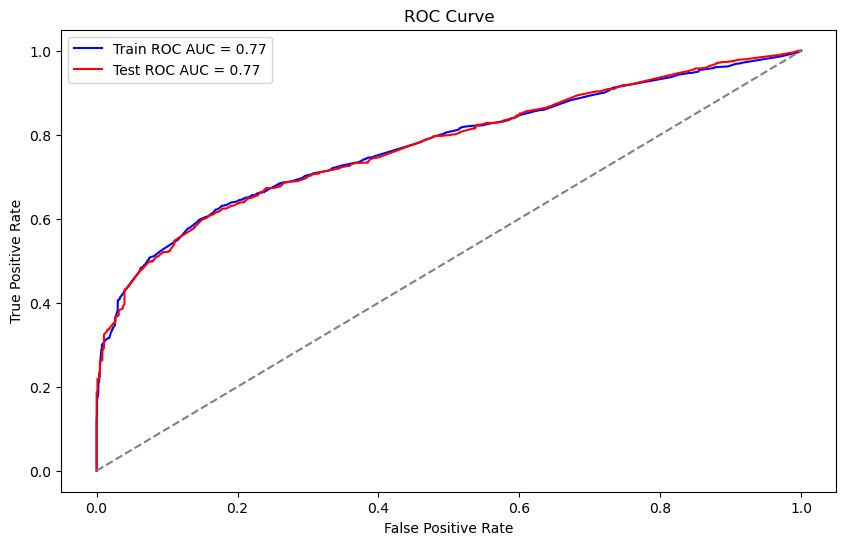

Train ROC AUC: 0.8030748614442882
Test ROC AUC: 0.7905624386539992


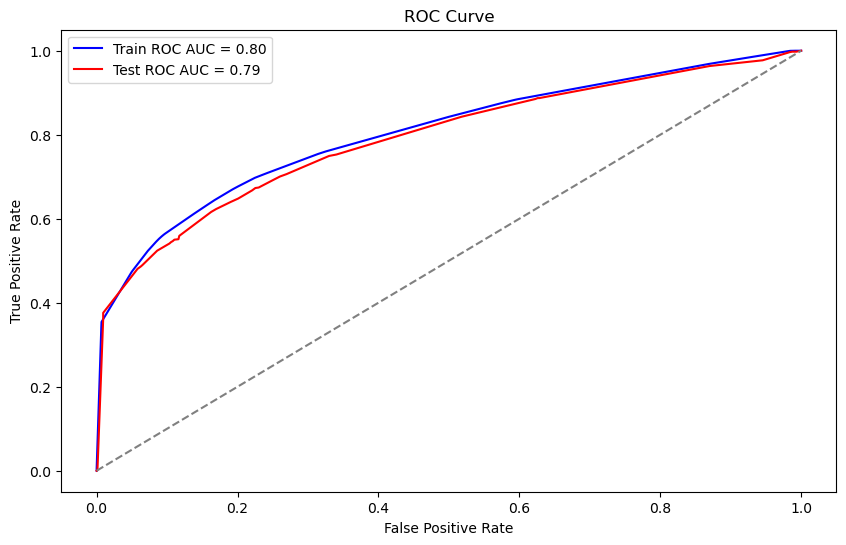

In [39]:
spaceTitanic.update_BaselineLogit()

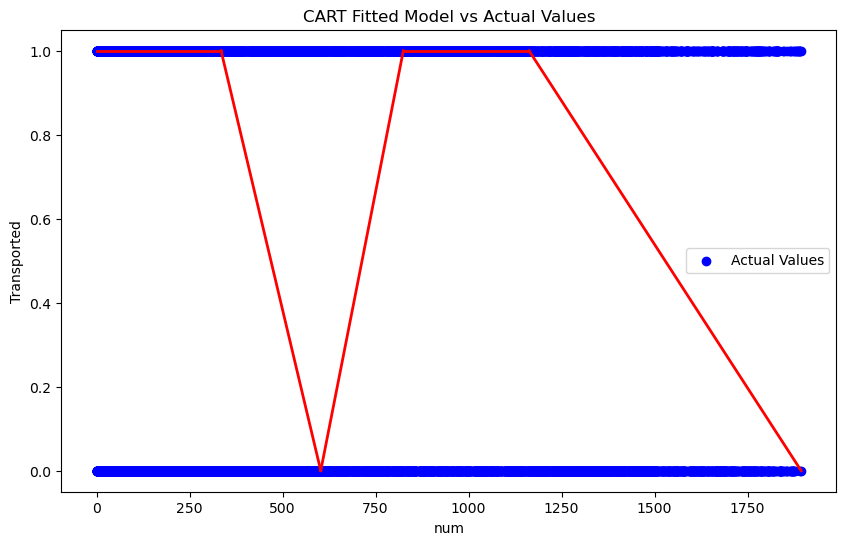

Done merging with Master Dataframe!


In [40]:
spaceTitanic.addNumericalBinHots('num', 5, 'Dev', n_jobs=2)

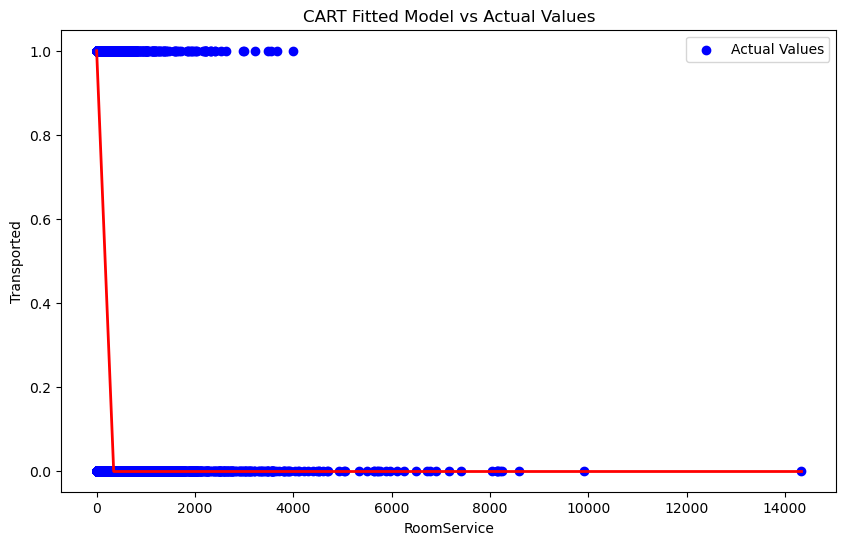

Done merging with Master Dataframe!


In [41]:
spaceTitanic.addNumericalBinHots('RoomService', 3, 'Dev', n_jobs=2)

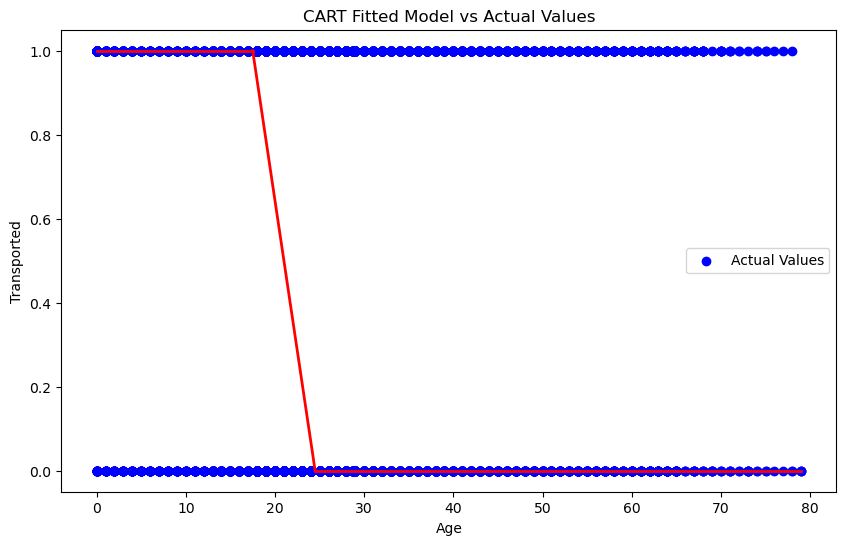

Done merging with Master Dataframe!


In [42]:
spaceTitanic.addNumericalBinHots('Age', 4, 'Dev', n_jobs=2)

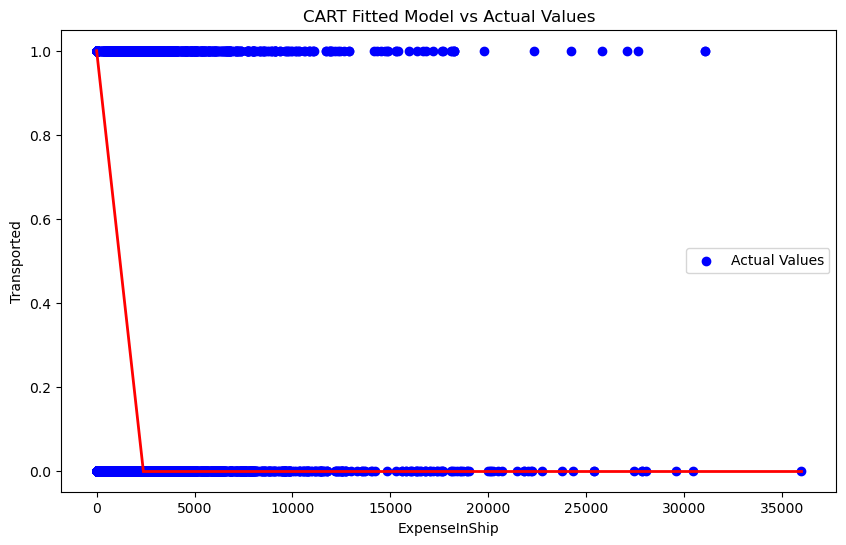

Done merging with Master Dataframe!


In [43]:
spaceTitanic.addNumericalBinHots('ExpenseInShip', 3, 'Dev', n_jobs=2)

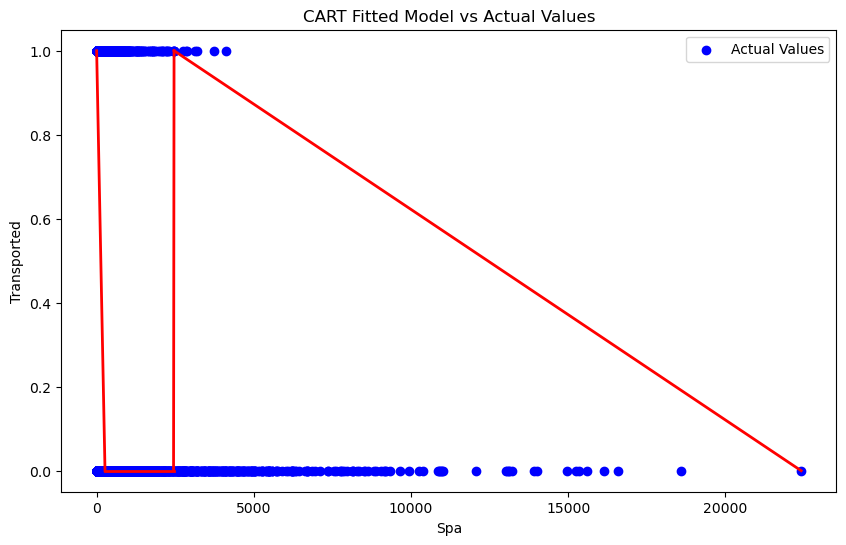

Done merging with Master Dataframe!


In [44]:
spaceTitanic.addNumericalBinHots('Spa', 5, 'Dev', n_jobs=2)

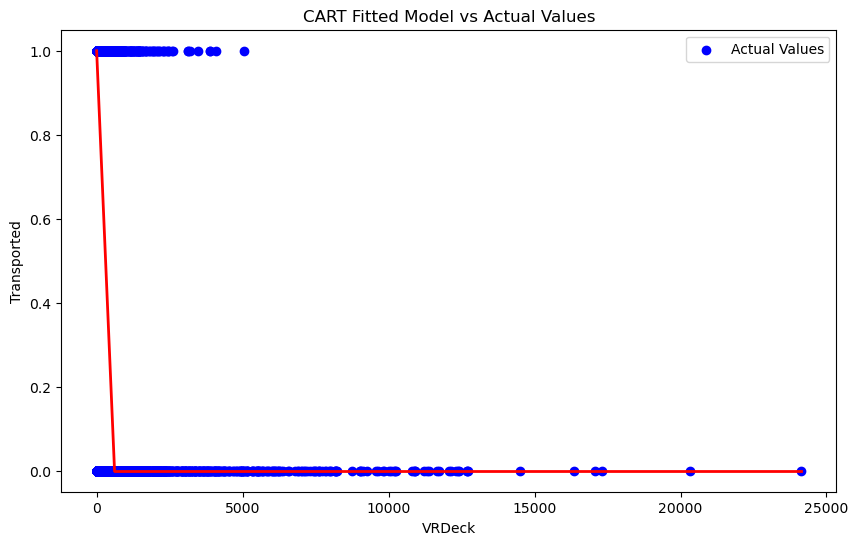

Done merging with Master Dataframe!


In [45]:
spaceTitanic.addNumericalBinHots('VRDeck', 3, 'Dev', n_jobs=2)

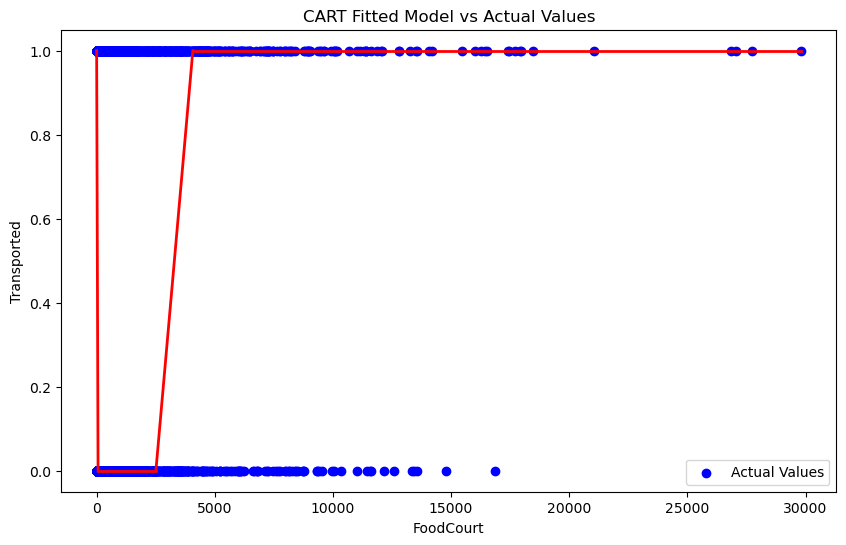

Done merging with Master Dataframe!


In [46]:
spaceTitanic.addNumericalBinHots('FoodCourt', 6, 'Dev', n_jobs=2)

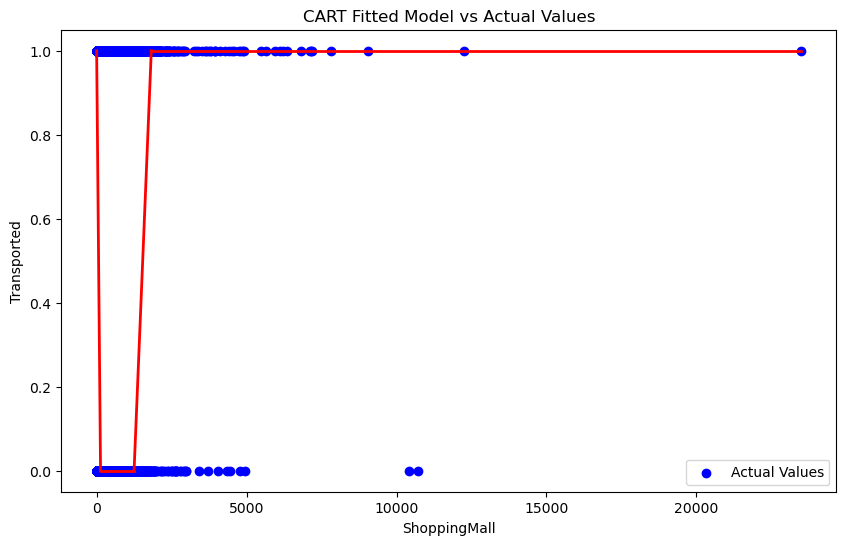

Done merging with Master Dataframe!


In [47]:
spaceTitanic.addNumericalBinHots('ShoppingMall', 7, 'Dev', n_jobs=2)

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.12453D-01

At iterate    1    f=  5.67608D-01    |proj g|=  5.48035D-02

At iterate    2    f=  5.59626D-01    |proj g|=  1.12847D-01

At iterate    3    f=  5.21678D-01    |proj g|=  2.79023D-02

At iterate    4    f=  5.12770D-01    |proj g|=  1.80730D-02

At iterate    5    f=  5.00141D-01    |proj g|=  2.55957D-02

At iterate    6    f=  4.82647D-01    |proj g|=  2.83779D-02

At iterate    7    f=  4.66997D-01    |proj g|=  2.31473D-02

At iterate    8    f=  4.58303D-01    |proj g|=  8.05301D-03

At iterate    9    f=  4.54913D-01    |proj g|=  8.69213D-03

At iterate   10    f=  4.45214D-01    |proj g|=  7.64747D-03

At iterate   11    f=  4.38206D-01    |proj g|=  5.12929D-03

At iterate   12    f=  4.34571D-01    |proj g|=  2.58289D-03

At iterate   13    f=  4.3

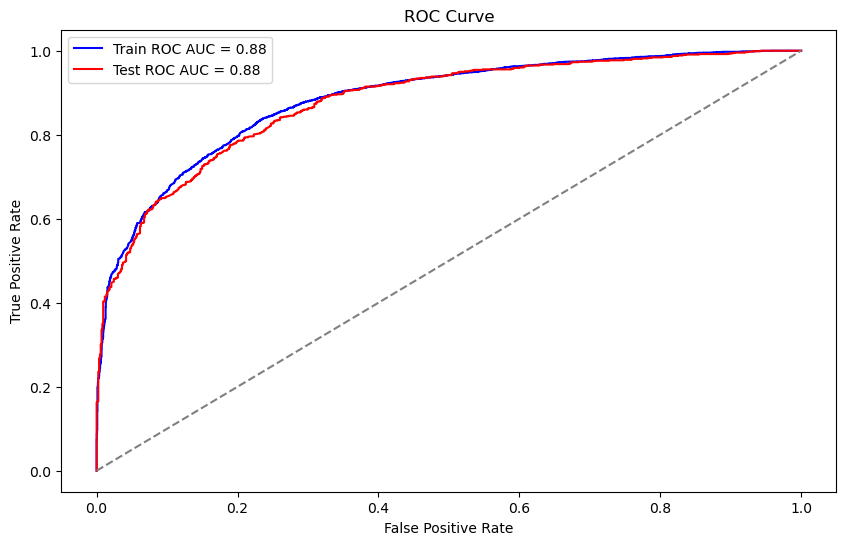

Train ROC AUC: 0.9046361154768799
Test ROC AUC: 0.8660534050833512


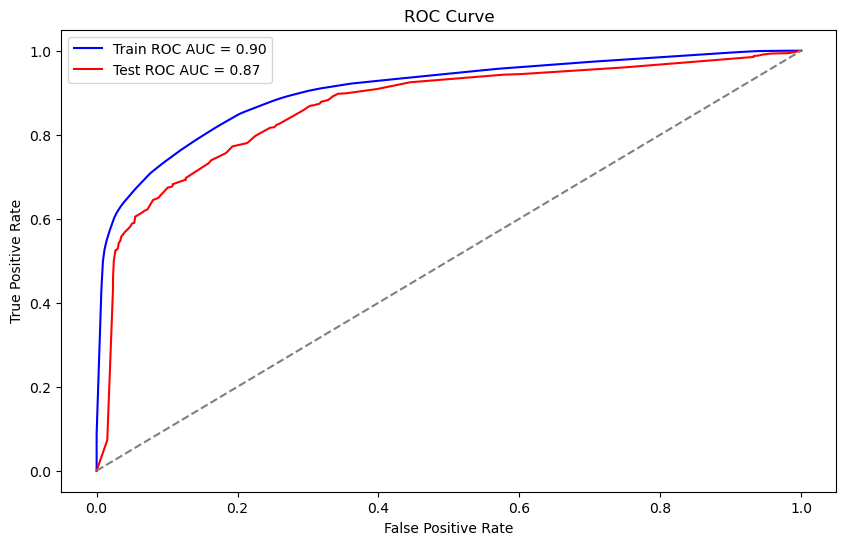

In [49]:
spaceTitanic.update_BaselineLogit()

In [ ]:
spaceTitanic.

In [42]:
spaceTitanic.baselineCols

['HomePlanet_Europa',
 'HomePlanet_Mars',
 'CryoSleep_True',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'VIP_True',
 'SibSp_2',
 'SibSp_3',
 'SibSp_4',
 'SibSp_5',
 'SibSp_6',
 'SibSp_7',
 'SibSp_8',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_T',
 'side_S',
 'num_0.00to334.50',
 'num_334.50to602.50',
 'num_602.50to824.50',
 'num_824.50to1162.50',
 'num_1162.50to1894.00',
 'RoomService_0.00to0.50',
 'RoomService_0.50to346.50',
 'RoomService_346.50to14327.00',
 'Age_0.00to4.50',
 'Age_4.50to17.50',
 'Age_17.50to24.50',
 'Age_24.50to79.00',
 'ExpenseInShip_0.00to0.50',
 'ExpenseInShip_0.50to2384.50',
 'ExpenseInShip_2384.50to35987.00',
 'Spa_0.00to0.50',
 'Spa_0.50to266.50',
 'Spa_266.50to2446.50',
 'Spa_2446.50to2462.50',
 'Spa_2462.50to22408.00',
 'VRDeck_0.00to0.50',
 'VRDeck_0.50to613.50',
 'VRDeck_613.50to24133.00',
 'FoodCourt_0.00to0.50',
 'FoodCourt_0.50to60.50',
 'FoodCourt_60.50to668.50',
 'FoodCourt_668.50to2507.50',
 'FoodCourt_250

In [60]:
logit_model = sm.Logit(spaceTitanic.masterDF[spaceTitanic.target].loc[:8692], sm.add_constant(spaceTitanic.masterDF[spaceTitanic.baselineCols].loc[:8692])).fit(method='lbfgs')
print(logit_model.summary())
cart_model = DecisionTreeClassifier(max_leaf_nodes=180, random_state=42)
cart_model.fit(spaceTitanic.masterDF[spaceTitanic.baselineCols].loc[:8692], spaceTitanic.masterDF[spaceTitanic.target].loc[:8692])
# 3. Predict on the Test Data
y_pred = cart_model.predict(spaceTitanic.masterDF[spaceTitanic.baselineCols].loc[8693:])
# threshold = 0.39
# y_prob = logit_model.predict(sm.add_constant(spaceTitanic.masterDF[spaceTitanic.baselineCols].loc[8693:]))
# y_pred = (y_prob >= threshold).astype(bool)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.12504D-01

At iterate    1    f=  5.67427D-01    |proj g|=  5.42973D-02

At iterate    2    f=  5.60002D-01    |proj g|=  1.13465D-01

At iterate    3    f=  5.21565D-01    |proj g|=  2.81241D-02

At iterate    4    f=  5.12697D-01    |proj g|=  1.81192D-02

At iterate    5    f=  5.00073D-01    |proj g|=  2.57621D-02

At iterate    6    f=  4.82881D-01    |proj g|=  2.82567D-02

At iterate    7    f=  4.67852D-01    |proj g|=  2.20344D-02

At iterate    8    f=  4.59598D-01    |proj g|=  7.77530D-03

At iterate    9    f=  4.56251D-01    |proj g|=  8.98299D-03

At iterate   10    f=  4.47193D-01    |proj g|=  8.26852D-03

At iterate   11    f=  4.39584D-01    |proj g|=  6.48768D-03

At iterate   12    f=  4.35909D-01    |proj g|=  3.79402D-03

At iterate   13    f=  4.3

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Transported   No. Observations:                 8693
Model:                          Logit   Df Residuals:                     8641
Method:                           MLE   Df Model:                           51
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.3781
Time:                        01:10:05   Log-Likelihood:                -3746.9
converged:                      False   LL-Null:                       -6025.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.0068        nan        nan        nan         nan         nan
HomePlanet_Europa                   0.9812        nan        nan    

In [62]:
y_pred

0.5732990413841478

# Submission 🎉

In [55]:
test_id = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv").PassengerId
test_id.shape

(4277,)

In [58]:
submit = pd.DataFrame()
submit['PassengerId'] = test_id
submit['Transported'] = y_pred.astype(bool)

In [59]:
submit

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [97]:
submit.to_csv("submission.csv", index=False)